In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [3]:
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])

C:\Users\andys\AppData\Local\Temp\ipykernel_39232\2429695252.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)


In [4]:
df['#Passengers_diff'] = df['#Passengers'].diff(periods=12)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   #Passengers       144 non-null    int64  
 1   #Passengers_diff  132 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.4 KB


In [5]:
df['#Passengers_diff'].fillna(method='backfill', inplace=True)

C:\Users\andys\AppData\Local\Temp\ipykernel_39232\2287783042.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['#Passengers_diff'].fillna(method='backfill', inplace=True)
C:\Users\andys\AppData\Local\Temp\ipykernel_39232\2287783042.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['#Passengers_diff'].fillna(method='backfill', inplace=True)


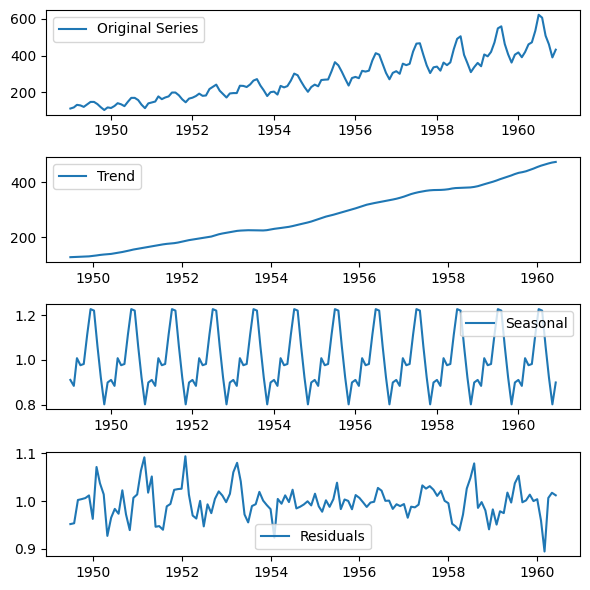

In [6]:
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# 1. Check Stationarity using ADF Test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def adf_test(series, name=''):
    """Augmented Dickey-Fuller test for stationarity"""
    print(f'--- ADF Test for {name} ---')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')
    if result[1] <= 0.05:
        print('Conclusion: Series is Stationary (reject null hypothesis)')
        return True
    else:
        print('Conclusion: Series is Non-Stationary (fail to reject null hypothesis)')
        return False

# Test original data
print("=" * 50)
is_stationary = adf_test(df['#Passengers'], 'Original #Passengers')
print("=" * 50)


--- ADF Test for Original #Passengers ---
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Non-Stationary (fail to reject null hypothesis)


In [8]:
# 2. Make the series stationary if needed
# Apply first differencing to remove trend
df['#Passengers_diff1'] = df['#Passengers'].diff(1)

# Test after first differencing
print("\n" + "=" * 50)
is_stationary_after_diff1 = adf_test(df['#Passengers_diff1'], 'First Differenced #Passengers')
print("=" * 50)

# Initialize differencing orders
d = 0  # first differencing order
D = 0  # seasonal differencing order

# If still not stationary, apply seasonal differencing
if not is_stationary_after_diff1:
    # Apply seasonal differencing (period=12 for monthly data)
    df['#Passengers_seasonal_diff'] = df['#Passengers'].diff(12)
    
    # Test after seasonal differencing
    print("\n" + "=" * 50)
    is_stationary_after_seasonal = adf_test(df['#Passengers_seasonal_diff'], 'Seasonally Differenced #Passengers')
    print("=" * 50)
    
    # If still not stationary, try both differencing and seasonal differencing
    if not is_stationary_after_seasonal:
        df['#Passengers_diff1_seasonal'] = df['#Passengers'].diff(1).diff(12)
        
        print("\n" + "=" * 50)
        is_stationary_final = adf_test(df['#Passengers_diff1_seasonal'], 'First + Seasonal Differenced #Passengers')
        print("=" * 50)
        
        # Use the final differenced series for ACF/PACF
        stationary_series = df['#Passengers_diff1_seasonal'].dropna()
        d = 1  # first differencing order
        D = 1  # seasonal differencing order
    else:
        # Use seasonal differenced series
        stationary_series = df['#Passengers_seasonal_diff'].dropna()
        d = 0  # no first differencing needed
        D = 1  # seasonal differencing order
else:
    # Use first differenced series
    stationary_series = df['#Passengers_diff1'].dropna()
    d = 1  # first differencing order
    D = 0  # no seasonal differencing needed

print(f"\nFinal differencing orders: d={d}, D={D}")
print(f"Using series: {'First + Seasonal Differenced' if (d==1 and D==1) else 'Seasonally Differenced' if D==1 else 'First Differenced' if d==1 else 'Original'}")



--- ADF Test for First Differenced #Passengers ---
ADF Statistic: -2.8293
p-value: 0.0542
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Non-Stationary (fail to reject null hypothesis)

--- ADF Test for Seasonally Differenced #Passengers ---
ADF Statistic: -3.3830
p-value: 0.0116
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Stationary (reject null hypothesis)

Final differencing orders: d=0, D=1
Using series: Seasonally Differenced


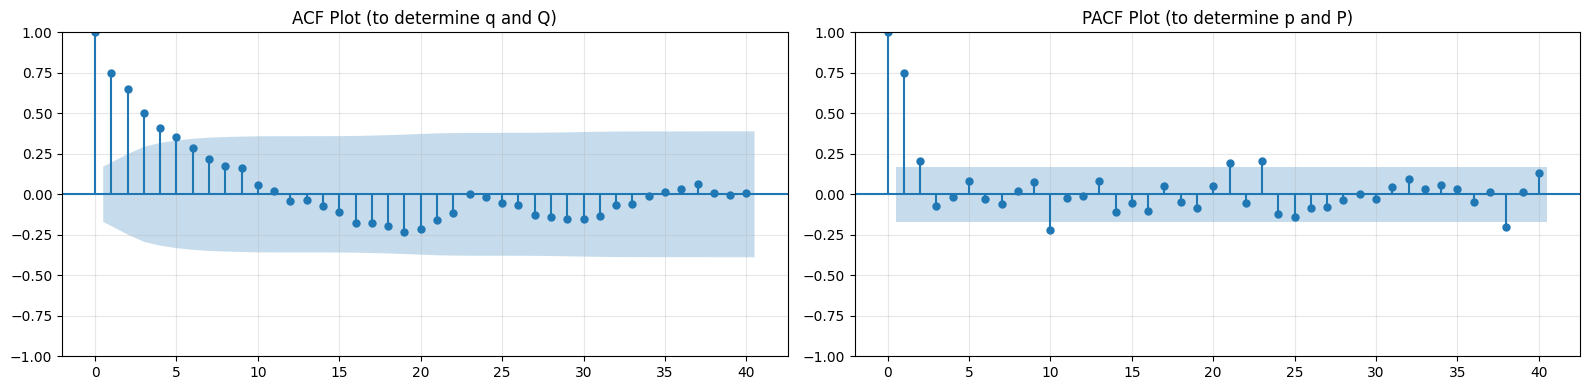


Guidelines for interpreting ACF and PACF plots:
- ACF: Cuts off after lag k → suggests MA(q) with q=k
- PACF: Cuts off after lag k → suggests AR(p) with p=k
- Seasonal patterns at lags 12, 24, 36, etc. indicate seasonal components
- Seasonal ACF: Cuts off at seasonal lag → Q
- Seasonal PACF: Cuts off at seasonal lag → P


In [ ]:
# 3. Plot ACF and PACF to determine p, q, P, Q orders
# Determine maximum lags (should be less than 50% of sample size)
max_lags = min(40, len(stationary_series) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(stationary_series, lags=max_lags, ax=axes[0], title='ACF Plot (to determine p and P)')
axes[0].grid(True, alpha=0.3)

# Plot PACF
plot_pacf(stationary_series, lags=max_lags, ax=axes[1], title='PACF Plot (to determine q and Q)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGuidelines for interpreting ACF and PACF plots:")
print("- ACF: Cuts off after lag k → suggests MA(q) with q=k")
print("- PACF: Cuts off after lag k → suggests AR(p) with p=k")
print("- Seasonal patterns at lags 12, 24, 36, etc. indicate seasonal components")
print("- Seasonal ACF: Cuts off at seasonal lag → Q")
print("- Seasonal PACF: Cuts off at seasonal lag → P")


In [12]:
# 4. Choose p, q, P, Q based on the plots
# Based on the ACF and PACF plots, make initial estimates
# This is a manual step - adjust based on your plots

# Example interpretation (adjust based on your actual plots):
# Looking at ACF: significant spikes at lag 1, then cuts off → q=1
# Looking at PACF: significant spikes at lag 1, then cuts off → p=1
# Seasonal lag 12 in ACF: significant spike → Q=1
# Seasonal lag 12 in PACF: significant spike → P=1

# Initial guess (adjust these based on your plots)
p = 1  # AR order (from PACF)
d = d  # Differencing order (from stationarity test)
q = 5  # MA order (from ACF)

P = 1  # Seasonal AR order (from PACF at seasonal lags)
D = D  # Seasonal differencing order (from stationarity test)
Q = 5  # Seasonal MA order (from ACF at seasonal lags)
s = 12  # Seasonal period (12 for monthly data)

print("=" * 50)
print("SARIMAX Order Selection")
print("=" * 50)
print(f"Non-seasonal orders: (p={p}, d={d}, q={q})")
print(f"Seasonal orders: (P={P}, D={D}, Q={Q}, s={s})")
print(f"Full SARIMAX order: SARIMAX({p},{d},{q})x({P},{D},{Q},{s})")
print("=" * 50)
print("\nNote: These are initial estimates. Consider using auto_arima or")
print("fitting multiple models to find the best parameters.")


SARIMAX Order Selection
Non-seasonal orders: (p=1, d=0, q=5)
Seasonal orders: (P=1, D=1, Q=5, s=12)
Full SARIMAX order: SARIMAX(1,0,5)x(1,1,5,12)

Note: These are initial estimates. Consider using auto_arima or
fitting multiple models to find the best parameters.


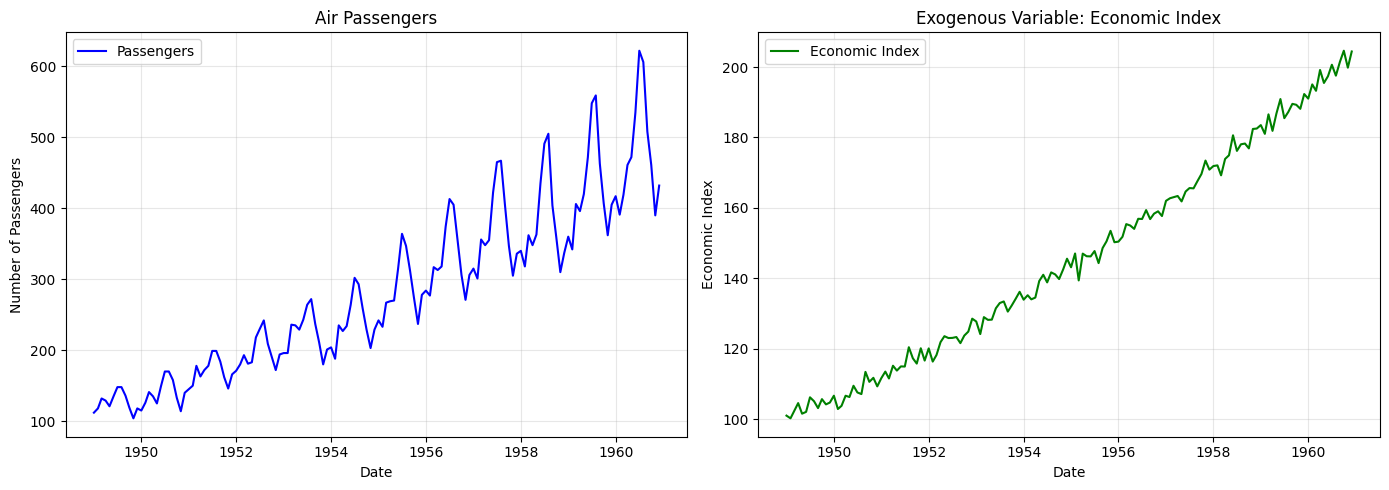


Exogenous Variable Statistics
       #Passengers  Economic_Index
count   144.000000      144.000000
mean    280.298611      145.775776
std     119.966317       30.379344
min     104.000000      100.223471
25%     180.000000      119.617173
50%     265.500000      142.819310
75%     360.500000      171.121152
max     622.000000      204.643748

Correlation: 0.9268


In [14]:
# 5. Create and prepare exogenous variable
# We'll create a synthetic GDP-like variable that explains passenger growth
# This simulates economic growth over time, which would influence air travel

np.random.seed(42)
# Create a trend variable (economic growth over time)
# Starting from a base value and growing with some noise
base_value = 100
growth_rate = 0.005  # 0.5% monthly growth
n_months = len(df)
time_trend = np.arange(n_months)
economic_index = base_value * (1 + growth_rate) ** time_trend
economic_index += np.random.normal(0, 2, n_months)  # Add some noise

# Store as exogenous variable
df['Economic_Index'] = economic_index

# Plot the exogenous variable
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(df.index, df['#Passengers'], label='Passengers', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(df.index, df['Economic_Index'], label='Economic Index', color='green')
plt.xlabel('Date')
plt.ylabel('Economic Index')
plt.title('Exogenous Variable: Economic Index')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("Exogenous Variable Statistics")
print("=" * 50)
print(df[['#Passengers', 'Economic_Index']].describe())
print(f"\nCorrelation: {df['#Passengers'].corr(df['Economic_Index']):.4f}")
print("=" * 50)


In [15]:
# 6. Check stationarity of exogenous variable and make it stationary if needed
print("=" * 50)
print("Checking Exogenous Variable Stationarity")
print("=" * 50)

is_exog_stationary = adf_test(df['Economic_Index'], 'Original Economic Index')
print("=" * 50)

# Make exogenous variable stationary if needed
if not is_exog_stationary:
    # Try first differencing
    df['Economic_Index_diff1'] = df['Economic_Index'].diff(1)
    is_exog_diff1_stationary = adf_test(df['Economic_Index_diff1'], 'First Differenced Economic Index')
    
    if is_exog_diff1_stationary:
        exog_stationary = df['Economic_Index_diff1'].dropna()
        exog_for_model = df['Economic_Index_diff1']
        print("\nUsing first differenced exogenous variable")
    else:
        # If still not stationary, use the differenced version anyway
        # SARIMAX can handle this through its own differencing
        exog_stationary = df['Economic_Index_diff1'].dropna()
        exog_for_model = df['Economic_Index_diff1']
        print("\nUsing first differenced exogenous variable (may need additional differencing in model)")
else:
    exog_for_model = df['Economic_Index']
    print("\nUsing original exogenous variable")

print("=" * 50)


Checking Exogenous Variable Stationarity
--- ADF Test for Original Economic Index ---
ADF Statistic: 4.0353
p-value: 1.0000
Critical Values:
  1%: -3.4805
  5%: -2.8835
  10%: -2.5785
Conclusion: Series is Non-Stationary (fail to reject null hypothesis)
--- ADF Test for First Differenced Economic Index ---
ADF Statistic: -7.9625
p-value: 0.0000
Critical Values:
  1%: -3.4790
  5%: -2.8829
  10%: -2.5781
Conclusion: Series is Stationary (reject null hypothesis)

Using first differenced exogenous variable


In [16]:
# 7. Split data into train and test sets
# Use 80% for training and 20% for testing
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print("=" * 50)
print("Data Split")
print("=" * 50)
print(f"Training data: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test data: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")
print("=" * 50)

# Prepare exogenous variables for train and test
exog_train = train_data['Economic_Index'].values.reshape(-1, 1)
exog_test = test_data['Economic_Index'].values.reshape(-1, 1)


Data Split
Training data: 115 observations (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Test data: 29 observations (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


In [17]:
# 8. Fit SARIMAX model
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Use the orders determined earlier
# Adjusting to simpler model if needed (q=5 might be too complex)
# Starting with (1,0,1)x(1,1,1,12) and can adjust

print("=" * 50)
print("Fitting SARIMAX Model")
print("=" * 50)
print(f"Model: SARIMAX({p},{d},{q})x({P},{D},{Q},{s})")
print(f"With exogenous variable: Economic_Index")
print("Fitting model... This may take a moment...")
print("=" * 50)

# Fit the model
model = sm.tsa.SARIMAX(
    train_data['#Passengers'],
    exog=exog_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
results = model.fit(disp=False)

# Print model summary
print("\n" + "=" * 50)
print("SARIMAX Model Summary")
print("=" * 50)
print(results.summary())
print("=" * 50)


Fitting SARIMAX Model
Model: SARIMAX(1,0,5)x(1,1,5,12)
With exogenous variable: Economic_Index
Fitting model... This may take a moment...

SARIMAX Model Summary
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  115
Model:             SARIMAX(1, 0, 5)x(1, 1, 5, 12)   Log Likelihood                -122.844
Date:                            Fri, 14 Nov 2025   AIC                            273.688
Time:                                    12:09:54   BIC                            296.241
Sample:                                01-01-1949   HQIC                           281.639
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [18]:
# 9. Forecast on test set
print("=" * 50)
print("Forecasting on Test Set")
print("=" * 50)

# Get forecast for the test period
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps, exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
}, index=test_data.index)

# Actual values
actual_values = test_data['#Passengers']

print(f"Forecasted {forecast_steps} steps ahead")
print("\nFirst few forecast values:")
print(forecast_df.head())
print("\nFirst few actual values:")
print(actual_values.head())


Forecasting on Test Set
Forecasted 29 steps ahead

First few forecast values:
              Forecast    Lower CI    Upper CI
Month                                         
1958-08-01  495.405394  483.851859  506.958930
1958-09-01  432.212292  417.391467  447.033117
1958-10-01  376.258665  357.369599  395.147732
1958-11-01  325.944959  301.571244  350.318674
1958-12-01  359.753838  333.098660  386.409015

First few actual values:
Month
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
Name: #Passengers, dtype: int64


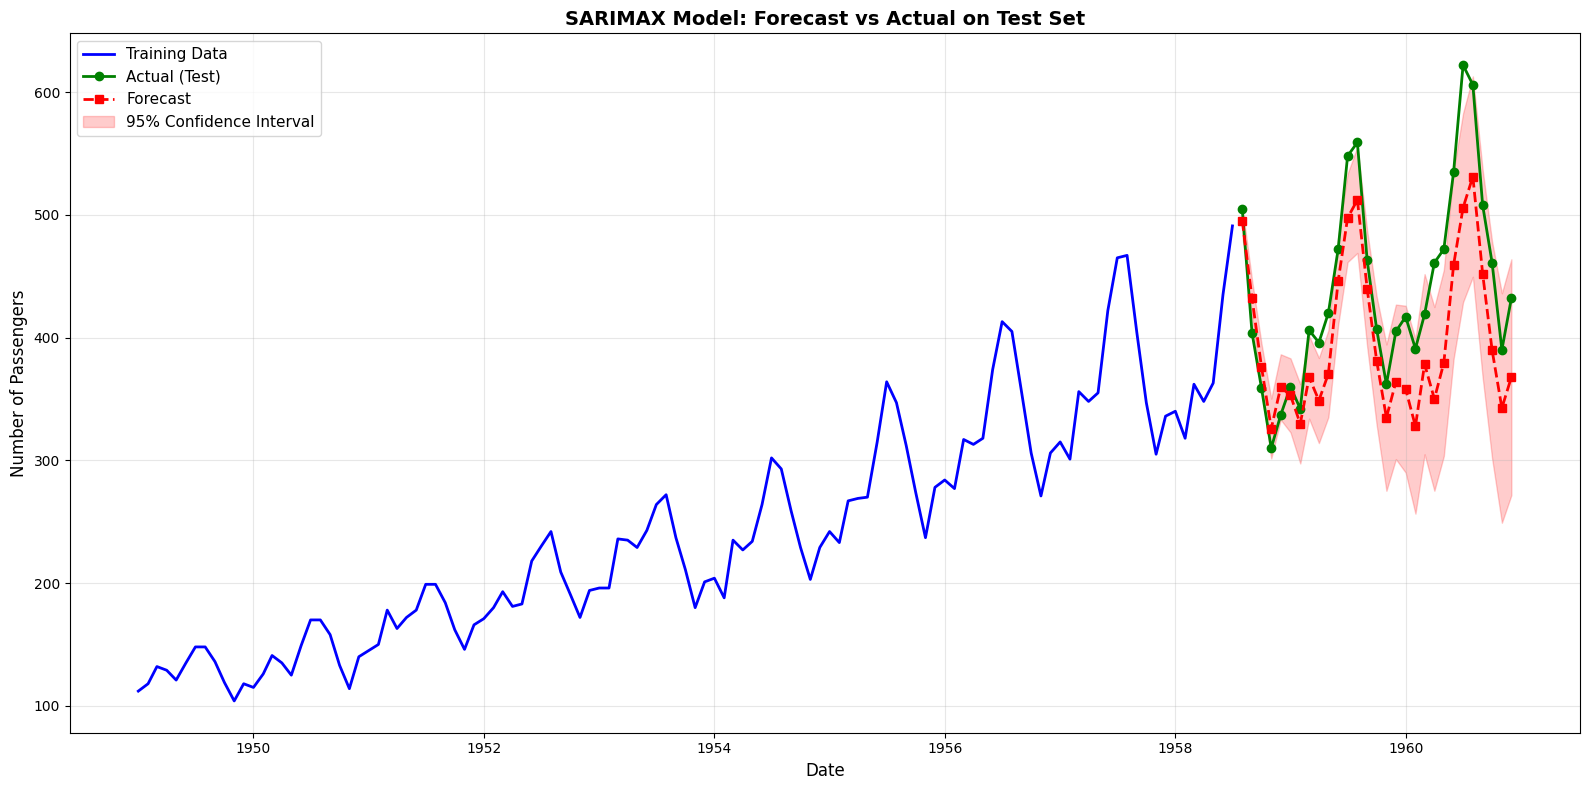

In [19]:
# 10. Visualize forecast vs actual
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)

# Plot test data (actual)
plt.plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')

# Plot forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linewidth=2, linestyle='--', marker='s')

# Plot confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.title('SARIMAX Model: Forecast vs Actual on Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# 11. Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Calculate metrics
mae = mean_absolute_error(actual_values, forecast_mean)
mse = mean_squared_error(actual_values, forecast_mean)
rmse = math.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - forecast_mean) / actual_values)) * 100

# Mean Percentage Error (MPE)
mpe = np.mean((actual_values - forecast_mean) / actual_values) * 100

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Actual': actual_values.values,
    'Forecast': forecast_mean.values,
    'Error': (actual_values - forecast_mean).values,
    'Absolute Error': np.abs((actual_values - forecast_mean).values),
    'Percentage Error': ((actual_values - forecast_mean) / actual_values * 100).values
}, index=test_data.index)

print("=" * 70)
print("MODEL EVALUATION METRICS")
print("=" * 70)
print(f"Mean Absolute Error (MAE):           {mae:.2f}")
print(f"Mean Squared Error (MSE):            {mse:.2f}")
print(f"Root Mean Squared Error (RMSE):      {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Percentage Error (MPE):         {mpe:.2f}%")
print("=" * 70)

print("\n" + "=" * 70)
print("DETAILED FORECAST COMPARISON")
print("=" * 70)
print(comparison_df.to_string())
print("=" * 70)


MODEL EVALUATION METRICS
Mean Absolute Error (MAE):           46.91
Mean Squared Error (MSE):            2991.00
Root Mean Squared Error (RMSE):      54.69
Mean Absolute Percentage Error (MAPE): 10.30%
Mean Percentage Error (MPE):         8.67%

DETAILED FORECAST COMPARISON
            Actual    Forecast       Error  Absolute Error  Percentage Error
Month                                                                       
1958-08-01     505  495.405394    9.594606        9.594606          1.899922
1958-09-01     404  432.212292  -28.212292       28.212292         -6.983241
1958-10-01     359  376.258665  -17.258665       17.258665         -4.807428
1958-11-01     310  325.944959  -15.944959       15.944959         -5.143535
1958-12-01     337  359.753838  -22.753838       22.753838         -6.751881
1959-01-01     360  352.949897    7.050103        7.050103          1.958362
1959-02-01     342  329.743804   12.256196       12.256196          3.583683
1959-03-01     406  367.733453  

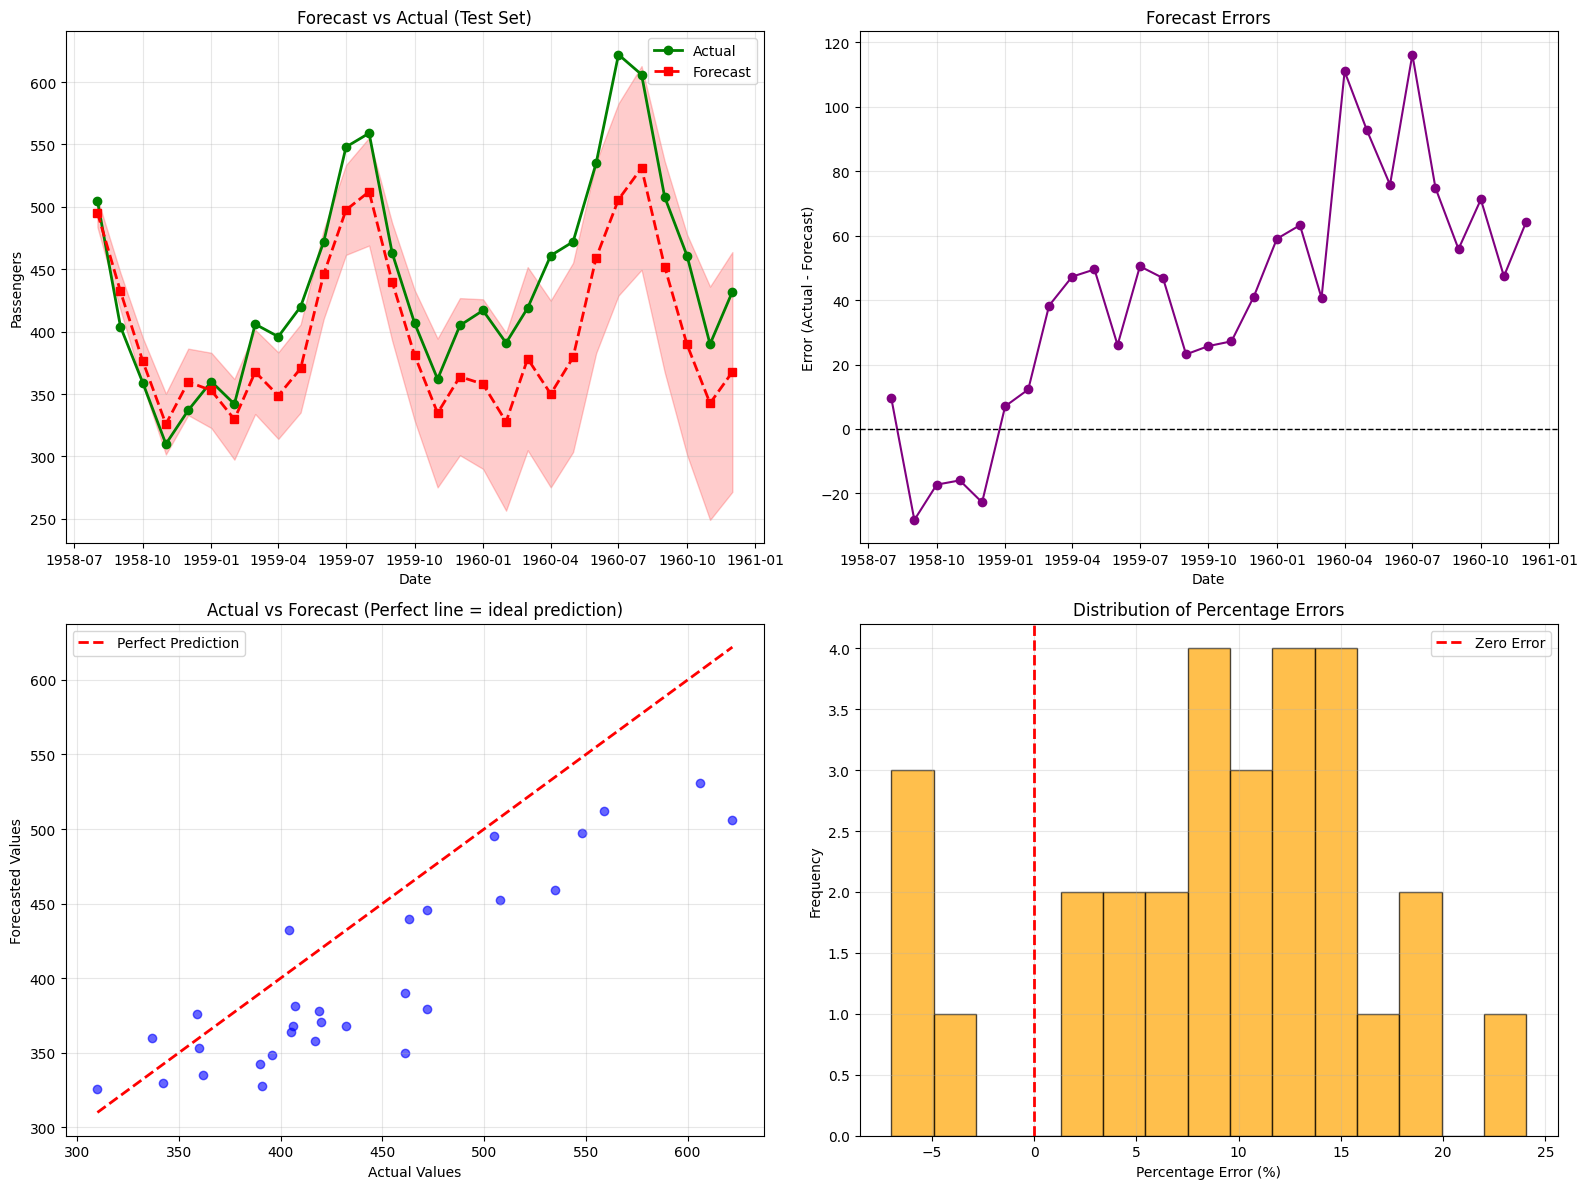


ERROR STATISTICS
Mean Error:                  41.10
Std Deviation of Errors:     36.72
Min Error:                   -28.21
Max Error:                   116.13
Mean Absolute Percentage Error: 10.30%


In [21]:
# 12. Additional visualizations for model evaluation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Forecast vs Actual (zoomed on test set)
axes[0, 0].plot(test_data.index, actual_values, label='Actual', color='green', linewidth=2, marker='o')
axes[0, 0].plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linewidth=2, linestyle='--', marker='s')
axes[0, 0].fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], 
                        color='red', alpha=0.2)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Passengers')
axes[0, 0].set_title('Forecast vs Actual (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals (Errors)
axes[0, 1].plot(test_data.index, comparison_df['Error'], color='purple', marker='o')
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Error (Actual - Forecast)')
axes[0, 1].set_title('Forecast Errors')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot: Actual vs Forecast
axes[1, 0].scatter(actual_values, forecast_mean, alpha=0.6, color='blue')
min_val = min(actual_values.min(), forecast_mean.min())
max_val = max(actual_values.max(), forecast_mean.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Forecasted Values')
axes[1, 0].set_title('Actual vs Forecast (Perfect line = ideal prediction)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Percentage Error Distribution
axes[1, 1].hist(comparison_df['Percentage Error'], bins=15, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Percentage Errors')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("ERROR STATISTICS")
print("=" * 70)
print(f"Mean Error:                  {comparison_df['Error'].mean():.2f}")
print(f"Std Deviation of Errors:     {comparison_df['Error'].std():.2f}")
print(f"Min Error:                   {comparison_df['Error'].min():.2f}")
print(f"Max Error:                   {comparison_df['Error'].max():.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print("=" * 70)


In [22]:
# 13. Model Quality Assessment
print("\n" + "=" * 70)
print("MODEL QUALITY ASSESSMENT")
print("=" * 70)

print("\n1. ACCURACY METRICS:")
print(f"   • RMSE: {rmse:.2f} passengers")
print(f"   • MAPE: {mape:.2f}% (Lower is better, <10% is excellent, <20% is good)")
print(f"   • MAE:  {mae:.2f} passengers")

print("\n2. BIAS ASSESSMENT:")
if abs(mpe) < 1:
    bias_assessment = "Excellent - Model is nearly unbiased"
elif abs(mpe) < 5:
    bias_assessment = "Good - Model has low bias"
elif abs(mpe) < 10:
    bias_assessment = "Acceptable - Model has moderate bias"
else:
    bias_assessment = "Poor - Model has high bias"
print(f"   • MPE: {mpe:.2f}% ({bias_assessment})")

print("\n3. FORECAST RELIABILITY:")
# Check how many actual values fall within confidence interval
within_ci = ((actual_values >= forecast_df['Lower CI']) & 
             (actual_values <= forecast_df['Upper CI'])).sum()
ci_coverage = (within_ci / len(actual_values)) * 100
print(f"   • Confidence Interval Coverage: {ci_coverage:.1f}% (Target: ~95%)")
if ci_coverage >= 90:
    ci_assessment = "Excellent - CI captures most actual values"
elif ci_coverage >= 80:
    ci_assessment = "Good - CI coverage is reasonable"
else:
    ci_assessment = "Poor - CI may be too narrow"
print(f"   • Assessment: {ci_assessment}")

print("\n4. OVERALL MODEL PERFORMANCE:")
if mape < 10 and ci_coverage >= 90:
    overall = "EXCELLENT - Model performs very well"
elif mape < 20 and ci_coverage >= 80:
    overall = "GOOD - Model performance is acceptable"
elif mape < 30:
    overall = "FAIR - Model has room for improvement"
else:
    overall = "POOR - Model needs significant improvement"
print(f"   • {overall}")

print("\n" + "=" * 70)
print("RECOMMENDATIONS:")
print("=" * 70)
if mape > 20:
    print("• Consider trying different SARIMAX orders (p, d, q, P, D, Q)")
    print("• Try auto_arima to find optimal parameters")
if abs(mpe) > 5:
    print("• Model shows bias - consider including additional exogenous variables")
if ci_coverage < 90:
    print("• Confidence intervals may need adjustment - check model assumptions")
print("=" * 70)



MODEL QUALITY ASSESSMENT

1. ACCURACY METRICS:
   • RMSE: 54.69 passengers
   • MAPE: 10.30% (Lower is better, <10% is excellent, <20% is good)
   • MAE:  46.91 passengers

2. BIAS ASSESSMENT:
   • MPE: 8.67% (Acceptable - Model has moderate bias)

3. FORECAST RELIABILITY:
   • Confidence Interval Coverage: 69.0% (Target: ~95%)
   • Assessment: Poor - CI may be too narrow

4. OVERALL MODEL PERFORMANCE:
   • FAIR - Model has room for improvement

RECOMMENDATIONS:
• Model shows bias - consider including additional exogenous variables
• Confidence intervals may need adjustment - check model assumptions
